In [1]:
from keras.layers import *
import keras
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import backend as K

Using TensorFlow backend.


# Setup Google CoLab Environment

In [2]:
# Import data on Google CoLab
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/My\ Drive/Colab\ Notebooks/2.\ Autoencoder

# Importing relevant functions and libraries

In [3]:
%run "Reusable_Functions.ipynb"

# Import Data

In [19]:
db = import_DB('db4_5SS_full_train_s83552.npz')
y_train=db['out_motionData']
db = import_DB('db4_5SS_full_test_s20888.npz')
y_test=db['out_motionData']

db = import_DB('db5_5SS_part_noisy_train_s83552.npz')
x_train=db['in_motionData']
db = import_DB('db5_5SS_part_noisy_test_s20888.npz')
x_test=db['in_motionData']

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(83552, 25, 8)
(83552, 25, 7)
(20888, 25, 8)
(20888, 25, 7)


In [21]:
def sampling(args):
    mu, log_var = args
    batch_size = K.shape(mu)[0]
    z_dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch_size, z_dim))
    return mu + K.exp(0.5 * log_var) * eps

def eucledian_norm(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true)))
def kl(z_mean,z_log_var):
    return 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis=-1)

# Variational Autoencoder (VAE)

In [22]:
def VAE_train(VAE, modelname):
    # VISUALIZING MODEL ARCHITECTURE
    VAE.summary()
    display(SVG(model_to_dot(VAE, show_shapes=True, show_layer_names=True, dpi=70).create(prog='dot', format='svg')))
    
    # TRAINING
    filepath=os.path.join('models_VAE', modelname+'.hdf5')
    #earlyStopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min', restore_best_weights=True)
    chkpt = ModelCheckpoint(filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
    train_data=VAE.fit([x_train], [y_train], shuffle=True, epochs=250, batch_size=256, validation_data=([x_test], [y_test]), verbose=1, callbacks=[chkpt])
    
    # VISUALIZING LEARNING CURVES
    visualize_learning_curves(train_data)
    return train_data

def VAE_load(VAE, modelname):
    filepath=os.path.join('models_VAE', modelname+'.hdf5')
    #VAE=load_model(filepath, custom_objects={'rmse': rmse})
    VAE.load_weights(filepath)

## Fully Connected NN architecture: analyzing affect of Depth and Bottleneck width 

In [23]:
def VAE_FC(hidden=[100,100,100], z_dim=30):
    inp=Input(shape=(25,8))
    encDim=hidden
    decDim=hidden[::-1]

    # Encoding
    x=Flatten()(inp)
    for i in encDim:
        x=Dense(i, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    x=Dense(decDim[0], activation='relu')(z)
    for i in decDim[1:]:
        x=Dense(i, activation='relu')(x)
    x=Dense(175)(x)
    y=Reshape((25, 7))(x)
    
    # loss
    def reconstruction_loss(out_true, out_pred):
        return eucledian_norm(out_true, out_pred)
    def kl_loss(out_true, out_pred):
        return kl(z_mean,z_log_var)
    def vae_loss(out_true, out_pred):      
        return reconstruction_loss(out_true, out_pred) + kl_loss(out_true, out_pred)

    # build model
    vae = Model(inputs=[inp], outputs=[y])
    #vae.add_loss(vae_loss)
    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reconstruction_loss,kl_loss], )
    
    encoder = Model(inputs=[inp], outputs=[z_mean])
    return vae, encoder

In [24]:
vae_FC_h1_z15,_=VAE_FC([100],15)
vae_FC_h1_z30,_=VAE_FC([100],30)
vae_FC_h1_z60,_=VAE_FC([100],60)

vae_FC_h2_z15,_=VAE_FC([150,75],15)
vae_FC_h2_z30,_=VAE_FC([150,75],30)
vae_FC_h2_z60,_=VAE_FC([150,75],60)

vae_FC_h3_z15,_=VAE_FC([200,100,60],15)
vae_FC_h3_z30,_=VAE_FC([200,100,60],30)
vae_FC_h3_z60,_=VAE_FC([200,100,60],60)

vae_FC_h4_z15,_=VAE_FC([200,150,100,60],15)
vae_FC_h4_z30,_=VAE_FC([200,150,100,60],30)
vae_FC_h4_z60,_=VAE_FC([200,150,100,60],60)

### hidden=1, Z=15

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 25, 8)        0                                            
__________________________________________________________________________________________________
flatten_13 (Flatten)            (None, 200)          0           input_13[0][0]                   
__________________________________________________________________________________________________
dense_73 (Dense)                (None, 100)          20100       flatten_13[0][0]                 
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 15)           1515        dense_73[0][0]                   
___________________________________________________________________________________________

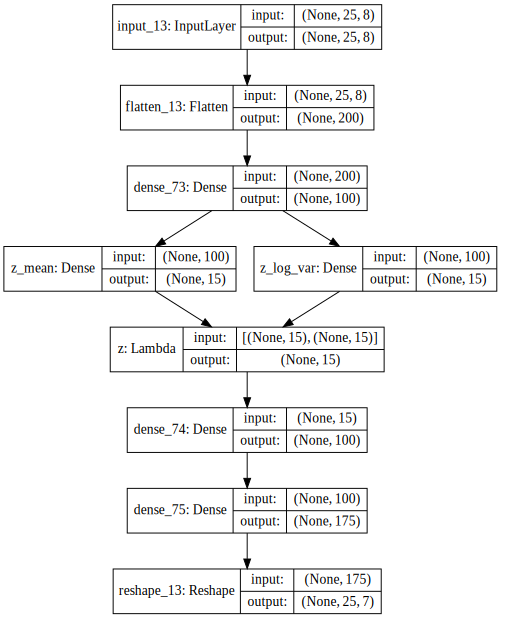

Train on 83552 samples, validate on 20888 samples
Epoch 1/250
83552/83552 [==============================] - 1s 12us/step - loss: 48.5311 - reconstruction_loss: 43.7242 - kl_loss: 4.7614 - val_loss: 33.5016 - val_reconstruction_loss: 28.0398 - val_kl_loss: 5.4351

Epoch 00001: val_loss improved from inf to 33.50157, saving model to models_VAE/VAE_FC_h1_z15.hdf5
Epoch 2/250
83552/83552 [==============================] - 1s 10us/step - loss: 37.2445 - reconstruction_loss: 31.5723 - kl_loss: 5.6473 - val_loss: 28.9109 - val_reconstruction_loss: 23.1252 - val_kl_loss: 5.7641

Epoch 00002: val_loss improved from 33.50157 to 28.91090, saving model to models_VAE/VAE_FC_h1_z15.hdf5
Epoch 3/250
83552/83552 [==============================] - 1s 10us/step - loss: 35.8534 - reconstruction_loss: 30.2353 - kl_loss: 5.5990 - val_loss: 27.8789 - val_reconstruction_loss: 22.0424 - val_kl_loss: 5.8158

Epoch 00003: val_loss improved from 28.91090 to 27.87891, saving model to models_VAE/VAE_FC_h1_z15.hdf


Epoch 00027: val_loss did not improve from 25.89048
Epoch 28/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.7087 - reconstruction_loss: 28.2798 - kl_loss: 5.4052 - val_loss: 25.8791 - val_reconstruction_loss: 20.1902 - val_kl_loss: 5.6706

Epoch 00028: val_loss improved from 25.89048 to 25.87915, saving model to models_VAE/VAE_FC_h1_z15.hdf5
Epoch 29/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.7000 - reconstruction_loss: 28.2714 - kl_loss: 5.4111 - val_loss: 25.8350 - val_reconstruction_loss: 20.0326 - val_kl_loss: 5.7827

Epoch 00029: val_loss improved from 25.87915 to 25.83504, saving model to models_VAE/VAE_FC_h1_z15.hdf5
Epoch 30/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.6744 - reconstruction_loss: 28.2550 - kl_loss: 5.4008 - val_loss: 25.8758 - val_reconstruction_loss: 20.1299 - val_kl_loss: 5.7276

Epoch 00030: val_loss did not improve from 25.83504
Epoch 31/250
83552/83552 [=============

83552/83552 [==============================] - 1s 10us/step - loss: 33.3529 - reconstruction_loss: 27.8691 - kl_loss: 5.4629 - val_loss: 25.4127 - val_reconstruction_loss: 19.5380 - val_kl_loss: 5.8570

Epoch 00056: val_loss did not improve from 25.40981
Epoch 57/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.3425 - reconstruction_loss: 27.8701 - kl_loss: 5.4516 - val_loss: 25.3431 - val_reconstruction_loss: 19.4374 - val_kl_loss: 5.8866

Epoch 00057: val_loss improved from 25.40981 to 25.34307, saving model to models_VAE/VAE_FC_h1_z15.hdf5
Epoch 58/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.3414 - reconstruction_loss: 27.8460 - kl_loss: 5.4737 - val_loss: 25.4414 - val_reconstruction_loss: 19.5689 - val_kl_loss: 5.8557

Epoch 00058: val_loss did not improve from 25.34307
Epoch 59/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.3515 - reconstruction_loss: 27.8486 - kl_loss: 5.4811 - val_loss: 25.4646

83552/83552 [==============================] - 1s 10us/step - loss: 33.1898 - reconstruction_loss: 27.6568 - kl_loss: 5.5125 - val_loss: 25.1474 - val_reconstruction_loss: 19.1077 - val_kl_loss: 6.0211

Epoch 00085: val_loss did not improve from 25.13944
Epoch 86/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.1761 - reconstruction_loss: 27.6448 - kl_loss: 5.5092 - val_loss: 25.2041 - val_reconstruction_loss: 19.2154 - val_kl_loss: 5.9711

Epoch 00086: val_loss did not improve from 25.13944
Epoch 87/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.2012 - reconstruction_loss: 27.6662 - kl_loss: 5.5157 - val_loss: 25.1730 - val_reconstruction_loss: 19.2408 - val_kl_loss: 5.9151

Epoch 00087: val_loss did not improve from 25.13944
Epoch 88/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.1629 - reconstruction_loss: 27.6418 - kl_loss: 5.5040 - val_loss: 25.1603 - val_reconstruction_loss: 19.2379 - val_kl_loss: 5


Epoch 00114: val_loss did not improve from 25.08088
Epoch 115/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.0686 - reconstruction_loss: 27.5119 - kl_loss: 5.5421 - val_loss: 25.1356 - val_reconstruction_loss: 19.2032 - val_kl_loss: 5.9143

Epoch 00115: val_loss did not improve from 25.08088
Epoch 116/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.0469 - reconstruction_loss: 27.4957 - kl_loss: 5.5298 - val_loss: 25.1242 - val_reconstruction_loss: 19.1849 - val_kl_loss: 5.9217

Epoch 00116: val_loss did not improve from 25.08088
Epoch 117/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.0431 - reconstruction_loss: 27.5039 - kl_loss: 5.5225 - val_loss: 25.1866 - val_reconstruction_loss: 19.2050 - val_kl_loss: 5.9636

Epoch 00117: val_loss did not improve from 25.08088
Epoch 118/250
83552/83552 [==============================] - 1s 10us/step - loss: 33.0384 - reconstruction_loss: 27.4854 - kl_loss: 5.5322 -

83552/83552 [==============================] - 1s 10us/step - loss: 32.9687 - reconstruction_loss: 27.3757 - kl_loss: 5.5724 - val_loss: 25.1014 - val_reconstruction_loss: 19.1438 - val_kl_loss: 5.9416

Epoch 00145: val_loss did not improve from 25.01931
Epoch 146/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.9879 - reconstruction_loss: 27.4073 - kl_loss: 5.5699 - val_loss: 25.0160 - val_reconstruction_loss: 18.9077 - val_kl_loss: 6.0924

Epoch 00146: val_loss improved from 25.01931 to 25.01600, saving model to models_VAE/VAE_FC_h1_z15.hdf5
Epoch 147/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.9332 - reconstruction_loss: 27.3525 - kl_loss: 5.5602 - val_loss: 25.1659 - val_reconstruction_loss: 19.1614 - val_kl_loss: 5.9868

Epoch 00147: val_loss did not improve from 25.01600
Epoch 148/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.9601 - reconstruction_loss: 27.3716 - kl_loss: 5.5667 - val_loss: 25.1

83552/83552 [==============================] - 1s 10us/step - loss: 32.9058 - reconstruction_loss: 27.2852 - kl_loss: 5.6023 - val_loss: 25.0618 - val_reconstruction_loss: 19.0477 - val_kl_loss: 5.9970

Epoch 00175: val_loss did not improve from 24.97741
Epoch 176/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.8735 - reconstruction_loss: 27.2606 - kl_loss: 5.5906 - val_loss: 25.0908 - val_reconstruction_loss: 19.1478 - val_kl_loss: 5.9246

Epoch 00176: val_loss did not improve from 24.97741
Epoch 177/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.8302 - reconstruction_loss: 27.2328 - kl_loss: 5.5772 - val_loss: 25.0927 - val_reconstruction_loss: 19.0971 - val_kl_loss: 5.9776

Epoch 00177: val_loss did not improve from 24.97741
Epoch 178/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.8532 - reconstruction_loss: 27.2451 - kl_loss: 5.5901 - val_loss: 25.1897 - val_reconstruction_loss: 19.1990 - val_kl_loss


Epoch 00205: val_loss did not improve from 24.97741
Epoch 206/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.7723 - reconstruction_loss: 27.1341 - kl_loss: 5.6161 - val_loss: 25.0753 - val_reconstruction_loss: 19.0371 - val_kl_loss: 6.0226

Epoch 00206: val_loss did not improve from 24.97741
Epoch 207/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.7597 - reconstruction_loss: 27.1303 - kl_loss: 5.6102 - val_loss: 25.1715 - val_reconstruction_loss: 19.1777 - val_kl_loss: 5.9769

Epoch 00207: val_loss did not improve from 24.97741
Epoch 208/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.7328 - reconstruction_loss: 27.1107 - kl_loss: 5.6058 - val_loss: 25.0498 - val_reconstruction_loss: 19.0261 - val_kl_loss: 6.0083

Epoch 00208: val_loss did not improve from 24.97741
Epoch 209/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.7495 - reconstruction_loss: 27.1100 - kl_loss: 5.6211 -

83552/83552 [==============================] - 1s 10us/step - loss: 32.6637 - reconstruction_loss: 27.0291 - kl_loss: 5.6146 - val_loss: 25.1032 - val_reconstruction_loss: 19.1725 - val_kl_loss: 5.9138

Epoch 00236: val_loss did not improve from 24.97741
Epoch 237/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.6302 - reconstruction_loss: 27.0006 - kl_loss: 5.6093 - val_loss: 25.2192 - val_reconstruction_loss: 19.3815 - val_kl_loss: 5.8199

Epoch 00237: val_loss did not improve from 24.97741
Epoch 238/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.6322 - reconstruction_loss: 26.9914 - kl_loss: 5.6248 - val_loss: 25.0610 - val_reconstruction_loss: 19.0292 - val_kl_loss: 6.0140

Epoch 00238: val_loss did not improve from 24.97741
Epoch 239/250
83552/83552 [==============================] - 1s 10us/step - loss: 32.6450 - reconstruction_loss: 27.0129 - kl_loss: 5.6111 - val_loss: 25.0973 - val_reconstruction_loss: 19.1198 - val_kl_loss

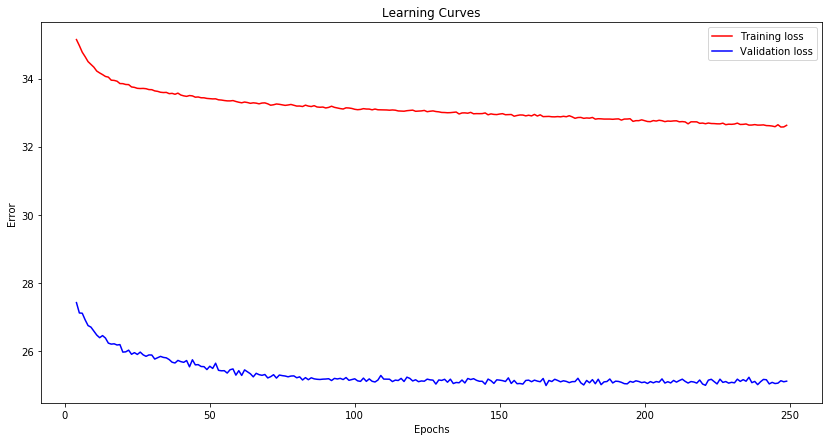

In [25]:
vae_Name='VAE_FC_h1_z15'
vae=vae_FC_h1_z15
train_data=VAE_train(vae, vae_Name)

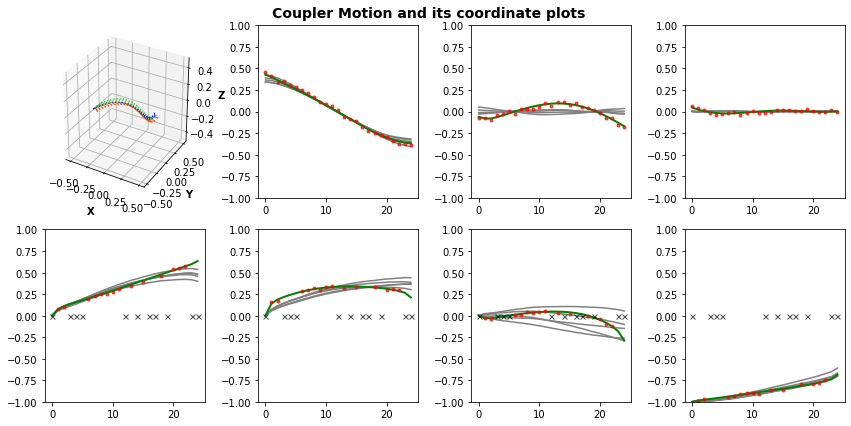

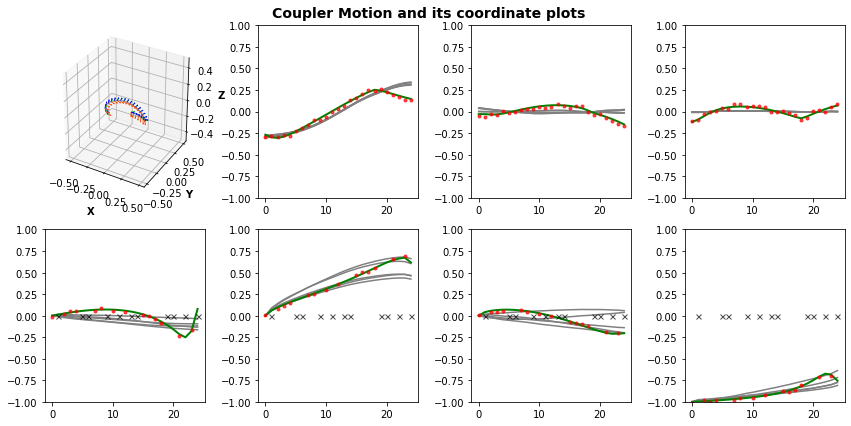

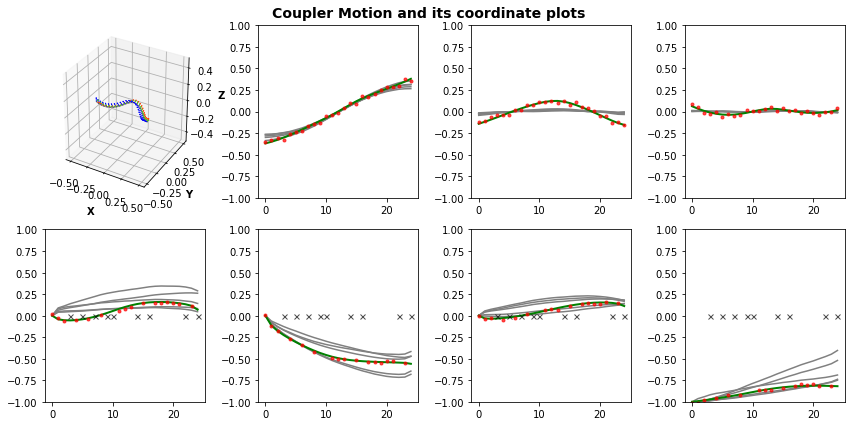

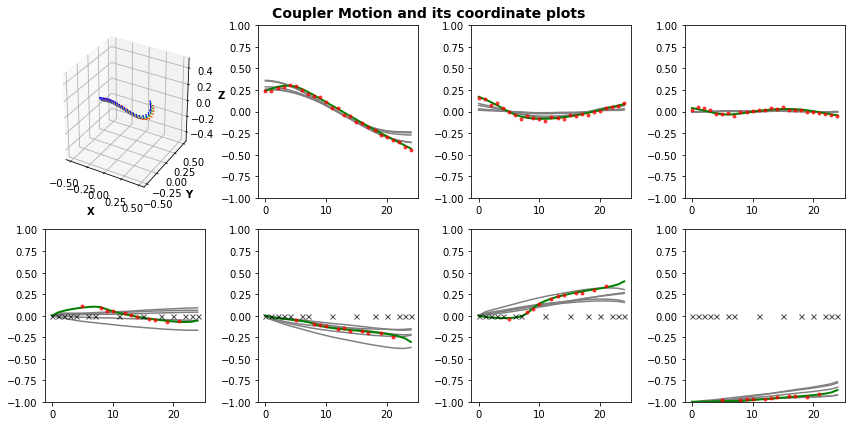

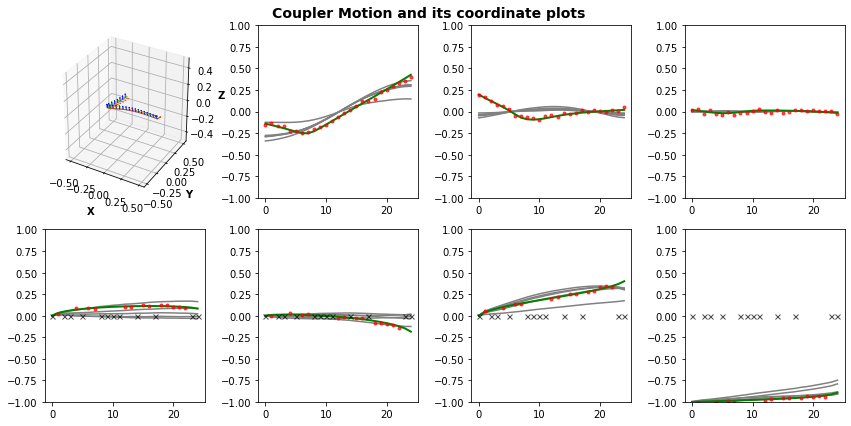

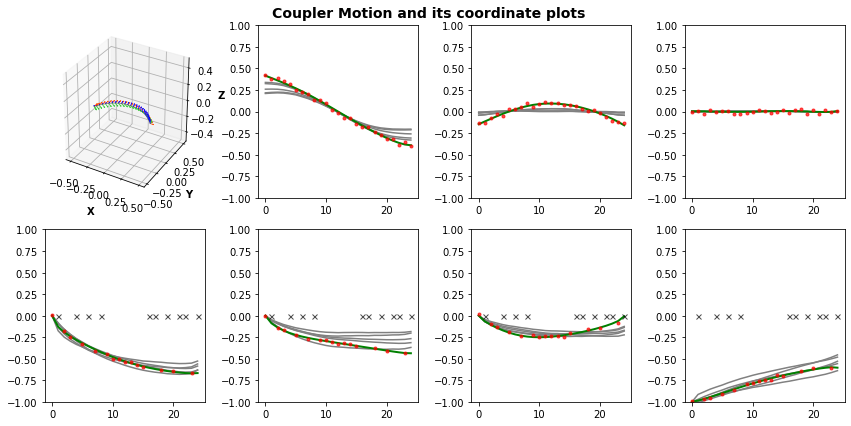

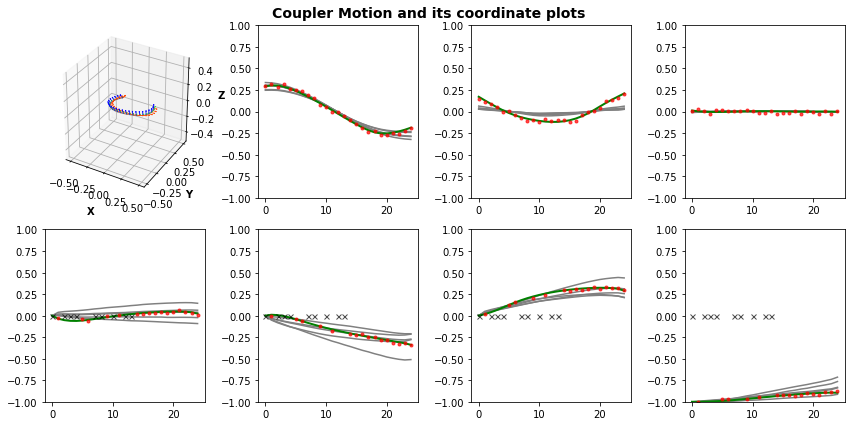

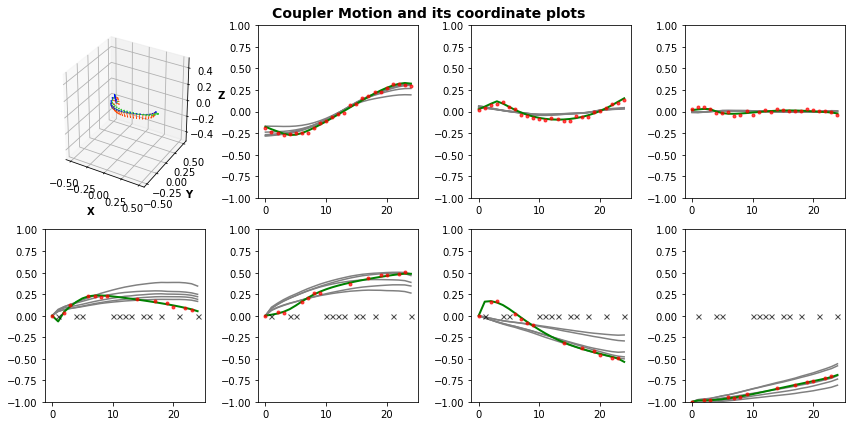

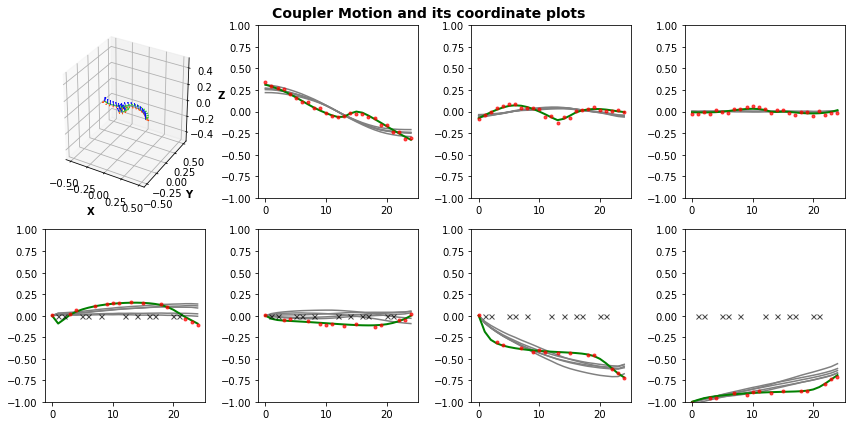

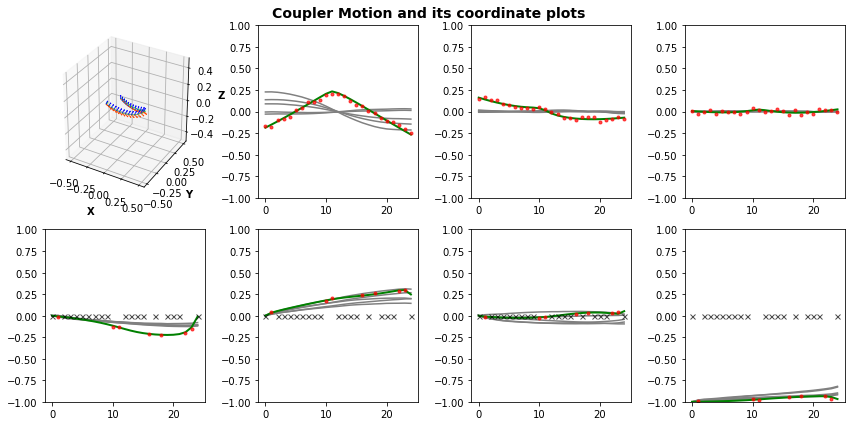

In [26]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### hidden=1, Z=30

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 25, 8)        0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 200)          0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100)          20100       flatten_2[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 30)           3030        dense_4[0][0]                    
____________________________________________________________________________________________

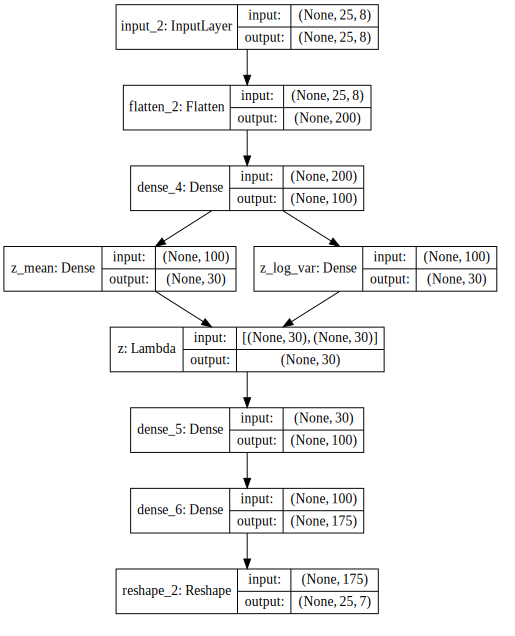

Train on 417760 samples, validate on 104440 samples
Epoch 1/250
417760/417760 [==============================] - 4s 10us/step - loss: 29.4104 - reconstruction_loss: 21.5696 - kl_loss: 7.8402 - val_loss: 24.3614 - val_reconstruction_loss: 15.8639 - val_kl_loss: 8.4976

Epoch 00001: val_loss improved from inf to 24.36138, saving model to models_VAE/VAE_FC_h1_z30.hdf5
Epoch 2/250
417760/417760 [==============================] - 4s 10us/step - loss: 23.9118 - reconstruction_loss: 14.9231 - kl_loss: 8.9886 - val_loss: 23.6452 - val_reconstruction_loss: 14.6744 - val_kl_loss: 8.9709

Epoch 00002: val_loss improved from 24.36138 to 23.64519, saving model to models_VAE/VAE_FC_h1_z30.hdf5
Epoch 3/250
417760/417760 [==============================] - 4s 10us/step - loss: 23.4970 - reconstruction_loss: 14.4735 - kl_loss: 9.0235 - val_loss: 23.3484 - val_reconstruction_loss: 14.2850 - val_kl_loss: 9.0635

Epoch 00003: val_loss improved from 23.64519 to 23.34841, saving model to models_VAE/VAE_FC_h1


Epoch 00027: val_loss improved from 22.29711 to 22.28888, saving model to models_VAE/VAE_FC_h1_z30.hdf5
Epoch 28/250
417760/417760 [==============================] - 4s 10us/step - loss: 22.3058 - reconstruction_loss: 13.0530 - kl_loss: 9.2527 - val_loss: 22.2690 - val_reconstruction_loss: 13.0610 - val_kl_loss: 9.2081

Epoch 00028: val_loss improved from 22.28888 to 22.26898, saving model to models_VAE/VAE_FC_h1_z30.hdf5
Epoch 29/250
417760/417760 [==============================] - 4s 10us/step - loss: 22.2891 - reconstruction_loss: 13.0378 - kl_loss: 9.2512 - val_loss: 22.2765 - val_reconstruction_loss: 13.0438 - val_kl_loss: 9.2328

Epoch 00029: val_loss did not improve from 22.26898
Epoch 30/250
417760/417760 [==============================] - 4s 10us/step - loss: 22.2807 - reconstruction_loss: 13.0307 - kl_loss: 9.2499 - val_loss: 22.2628 - val_reconstruction_loss: 13.1147 - val_kl_loss: 9.1481

Epoch 00030: val_loss improved from 22.26898 to 22.26275, saving model to models_VAE/

417760/417760 [==============================] - 4s 10us/step - loss: 22.1358 - reconstruction_loss: 12.8550 - kl_loss: 9.2807 - val_loss: 22.0979 - val_reconstruction_loss: 12.7646 - val_kl_loss: 9.3334

Epoch 00056: val_loss did not improve from 22.09415
Epoch 57/250
417760/417760 [==============================] - 4s 10us/step - loss: 22.1282 - reconstruction_loss: 12.8513 - kl_loss: 9.2768 - val_loss: 22.1628 - val_reconstruction_loss: 12.8919 - val_kl_loss: 9.2711

Epoch 00057: val_loss did not improve from 22.09415
Epoch 58/250
417760/417760 [==============================] - 4s 10us/step - loss: 22.1255 - reconstruction_loss: 12.8509 - kl_loss: 9.2745 - val_loss: 22.1119 - val_reconstruction_loss: 12.9352 - val_kl_loss: 9.1768

Epoch 00058: val_loss did not improve from 22.09415
Epoch 59/250
417760/417760 [==============================] - 4s 10us/step - loss: 22.1317 - reconstruction_loss: 12.8481 - kl_loss: 9.2836 - val_loss: 22.0905 - val_reconstruction_loss: 12.8448 - val_kl

KeyboardInterrupt: 

In [12]:
vae_Name='VAE_FC_h1_z30'
vae=vae_FC_h1_z30
train_data=VAE_train(vae, vae_Name)

In [ ]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### hidden=1, Z=60

In [ ]:
vae_Name='VAE_FC_h1_z60'
vae=vae_FC_h1_z60
train_data=VAE_train(vae, vae_Name)

In [ ]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### hidden=2, Z=15

In [ ]:
vae_Name='VAE_FC_h2_z15'
vae=vae_FC_h2_z15
train_data=VAE_train(vae, vae_Name)

In [ ]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### hidden=2, Z=30

In [ ]:
vae_Name='VAE_FC_h2_z30'
vae=vae_FC_h2_z30
train_data=VAE_train(vae, vae_Name)

In [ ]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### hidden=2, Z=60

In [ ]:
vae_Name='VAE_FC_h2_z60'
vae=vae_FC_h2_z60
train_data=VAE_train(vae, vae_Name)

In [ ]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### hidden=3, Z=15

In [ ]:
vae_Name='VAE_FC_h3_z15'
vae=vae_FC_h3_z15
train_data=VAE_train(vae, vae_Name)

In [ ]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### hidden=3, Z=30

In [ ]:
vae_Name='VAE_FC_h3_z30'
vae=vae_FC_h3_z30
train_data=VAE_train(vae, vae_Name)

In [ ]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### hidden=3, Z=60

In [ ]:
vae_Name='VAE_FC_h3_z60'
vae=vae_FC_h3_z60
train_data=VAE_train(vae, vae_Name)

In [ ]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### hidden=4, Z=15

In [ ]:
vae_Name='VAE_FC_h4_z15'
vae=vae_FC_h4_z15
train_data=VAE_train(vae, vae_Name)

In [ ]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### hidden=4, Z=30

In [ ]:
vae_Name='VAE_FC_h4_z30'
vae=vae_FC_h4_z30
train_data=VAE_train(vae, vae_Name)

In [ ]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### hidden=4, Z=60

Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 25, 8)        0                                            
__________________________________________________________________________________________________
flatten_24 (Flatten)            (None, 200)          0           input_24[0][0]                   
__________________________________________________________________________________________________
dense_136 (Dense)               (None, 200)          40200       flatten_24[0][0]                 
__________________________________________________________________________________________________
dense_137 (Dense)               (None, 150)          30150       dense_136[0][0]                  
___________________________________________________________________________________________

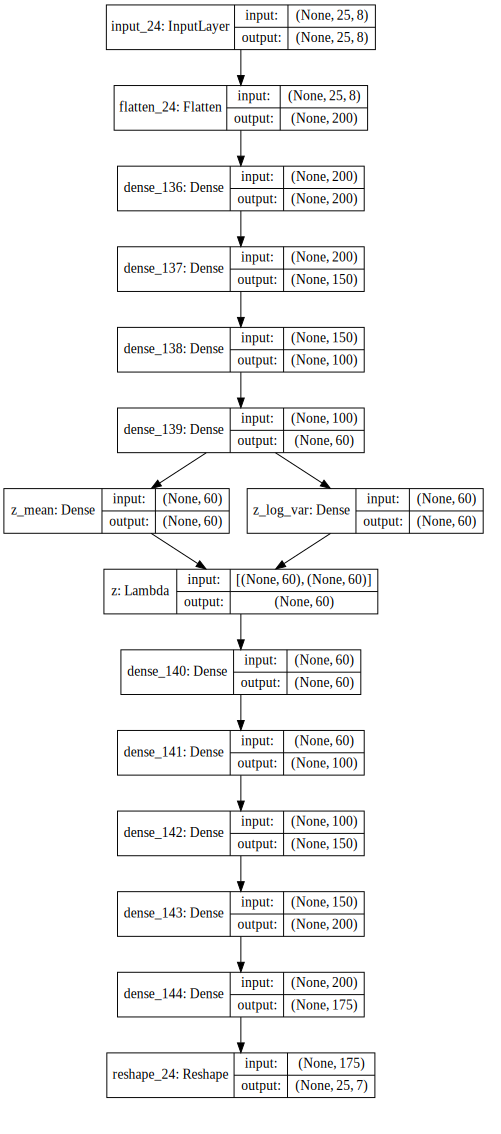

Train on 83552 samples, validate on 20888 samples
Epoch 1/250
83552/83552 [==============================] - 1s 17us/step - loss: 50.8042 - reconstruction_loss: 50.2143 - kl_loss: 0.5519 - val_loss: 48.6825 - val_reconstruction_loss: 47.8277 - val_kl_loss: 0.8018

Epoch 00001: val_loss improved from inf to 48.68247, saving model to models_VAE/VAE_FC_h4_z60.hdf5
Epoch 2/250
83552/83552 [==============================] - 1s 14us/step - loss: 48.5507 - reconstruction_loss: 47.8226 - kl_loss: 0.6905 - val_loss: 47.6131 - val_reconstruction_loss: 46.8846 - val_kl_loss: 0.6740

Epoch 00002: val_loss improved from 48.68247 to 47.61305, saving model to models_VAE/VAE_FC_h4_z60.hdf5
Epoch 3/250
83552/83552 [==============================] - 1s 14us/step - loss: 46.2551 - reconstruction_loss: 44.9957 - kl_loss: 1.2230 - val_loss: 42.4173 - val_reconstruction_loss: 40.4812 - val_kl_loss: 1.8850

Epoch 00003: val_loss improved from 47.61305 to 42.41734, saving model to models_VAE/VAE_FC_h4_z60.hdf

83552/83552 [==============================] - 1s 14us/step - loss: 34.4433 - reconstruction_loss: 29.9795 - kl_loss: 4.4380 - val_loss: 27.5463 - val_reconstruction_loss: 22.6330 - val_kl_loss: 4.8923

Epoch 00027: val_loss improved from 27.62186 to 27.54626, saving model to models_VAE/VAE_FC_h4_z60.hdf5
Epoch 28/250
83552/83552 [==============================] - 1s 14us/step - loss: 34.3915 - reconstruction_loss: 29.8408 - kl_loss: 4.5274 - val_loss: 27.4952 - val_reconstruction_loss: 22.3715 - val_kl_loss: 5.1025

Epoch 00028: val_loss improved from 27.54626 to 27.49524, saving model to models_VAE/VAE_FC_h4_z60.hdf5
Epoch 29/250
83552/83552 [==============================] - 1s 14us/step - loss: 34.1885 - reconstruction_loss: 29.6077 - kl_loss: 4.5537 - val_loss: 27.0506 - val_reconstruction_loss: 21.9223 - val_kl_loss: 5.1075

Epoch 00029: val_loss improved from 27.49524 to 27.05063, saving model to models_VAE/VAE_FC_h4_z60.hdf5
Epoch 30/250
83552/83552 [===========================

83552/83552 [==============================] - 1s 14us/step - loss: 33.4267 - reconstruction_loss: 28.4997 - kl_loss: 4.9022 - val_loss: 25.9611 - val_reconstruction_loss: 20.6857 - val_kl_loss: 5.2575

Epoch 00055: val_loss improved from 26.11175 to 25.96113, saving model to models_VAE/VAE_FC_h4_z60.hdf5
Epoch 56/250
83552/83552 [==============================] - 1s 14us/step - loss: 33.4028 - reconstruction_loss: 28.4778 - kl_loss: 4.8998 - val_loss: 26.0290 - val_reconstruction_loss: 20.6174 - val_kl_loss: 5.3923

Epoch 00056: val_loss did not improve from 25.96113
Epoch 57/250
83552/83552 [==============================] - 1s 14us/step - loss: 33.5040 - reconstruction_loss: 28.5467 - kl_loss: 4.9346 - val_loss: 26.5929 - val_reconstruction_loss: 21.1976 - val_kl_loss: 5.3748

Epoch 00057: val_loss did not improve from 25.96113
Epoch 58/250
83552/83552 [==============================] - 1s 14us/step - loss: 33.8706 - reconstruction_loss: 28.8119 - kl_loss: 5.0293 - val_loss: 26.1806

83552/83552 [==============================] - 1s 14us/step - loss: 32.9394 - reconstruction_loss: 27.9117 - kl_loss: 5.0121 - val_loss: 25.5831 - val_reconstruction_loss: 20.2576 - val_kl_loss: 5.3069

Epoch 00084: val_loss did not improve from 25.50378
Epoch 85/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.8509 - reconstruction_loss: 27.8516 - kl_loss: 4.9776 - val_loss: 25.5213 - val_reconstruction_loss: 19.9800 - val_kl_loss: 5.5229

Epoch 00085: val_loss did not improve from 25.50378
Epoch 86/250
83552/83552 [==============================] - 1s 14us/step - loss: 33.0632 - reconstruction_loss: 28.0752 - kl_loss: 4.9703 - val_loss: 26.1078 - val_reconstruction_loss: 20.8141 - val_kl_loss: 5.2760

Epoch 00086: val_loss did not improve from 25.50378
Epoch 87/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.9335 - reconstruction_loss: 27.9231 - kl_loss: 4.9891 - val_loss: 25.5644 - val_reconstruction_loss: 20.1208 - val_kl_loss: 5

83552/83552 [==============================] - 1s 14us/step - loss: 33.7002 - reconstruction_loss: 28.6212 - kl_loss: 5.0569 - val_loss: 27.4421 - val_reconstruction_loss: 21.8537 - val_kl_loss: 5.5668

Epoch 00114: val_loss did not improve from 25.30056
Epoch 115/250
83552/83552 [==============================] - 1s 14us/step - loss: 33.4238 - reconstruction_loss: 28.3295 - kl_loss: 5.0739 - val_loss: 26.7994 - val_reconstruction_loss: 21.2422 - val_kl_loss: 5.5336

Epoch 00115: val_loss did not improve from 25.30056
Epoch 116/250
83552/83552 [==============================] - 1s 14us/step - loss: 33.1238 - reconstruction_loss: 28.0223 - kl_loss: 5.0794 - val_loss: 26.5332 - val_reconstruction_loss: 21.0490 - val_kl_loss: 5.4638

Epoch 00116: val_loss did not improve from 25.30056
Epoch 117/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.8296 - reconstruction_loss: 27.7875 - kl_loss: 5.0222 - val_loss: 25.6203 - val_reconstruction_loss: 20.0552 - val_kl_loss


Epoch 00144: val_loss did not improve from 25.30056
Epoch 145/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.6580 - reconstruction_loss: 27.5553 - kl_loss: 5.0827 - val_loss: 26.1489 - val_reconstruction_loss: 20.5012 - val_kl_loss: 5.6272

Epoch 00145: val_loss did not improve from 25.30056
Epoch 146/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.6112 - reconstruction_loss: 27.4567 - kl_loss: 5.1303 - val_loss: 25.9887 - val_reconstruction_loss: 20.5707 - val_kl_loss: 5.3995

Epoch 00146: val_loss did not improve from 25.30056
Epoch 147/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.7080 - reconstruction_loss: 27.5605 - kl_loss: 5.1223 - val_loss: 25.9857 - val_reconstruction_loss: 20.4159 - val_kl_loss: 5.5518

Epoch 00147: val_loss did not improve from 25.30056
Epoch 148/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.5476 - reconstruction_loss: 27.4228 - kl_loss: 5.1016 -

83552/83552 [==============================] - 1s 14us/step - loss: 32.8502 - reconstruction_loss: 27.5571 - kl_loss: 5.2757 - val_loss: 26.0571 - val_reconstruction_loss: 20.3512 - val_kl_loss: 5.6868

Epoch 00175: val_loss did not improve from 25.30056
Epoch 176/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.4254 - reconstruction_loss: 27.2145 - kl_loss: 5.1886 - val_loss: 25.6456 - val_reconstruction_loss: 19.8315 - val_kl_loss: 5.7946

Epoch 00176: val_loss did not improve from 25.30056
Epoch 177/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.4773 - reconstruction_loss: 27.3062 - kl_loss: 5.1504 - val_loss: 26.0141 - val_reconstruction_loss: 20.4994 - val_kl_loss: 5.4950

Epoch 00177: val_loss did not improve from 25.30056
Epoch 178/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.5609 - reconstruction_loss: 27.3814 - kl_loss: 5.1578 - val_loss: 25.9117 - val_reconstruction_loss: 20.1635 - val_kl_loss


Epoch 00205: val_loss did not improve from 25.30056
Epoch 206/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.3068 - reconstruction_loss: 27.0320 - kl_loss: 5.2523 - val_loss: 25.6713 - val_reconstruction_loss: 19.7481 - val_kl_loss: 5.9046

Epoch 00206: val_loss did not improve from 25.30056
Epoch 207/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.4159 - reconstruction_loss: 27.1005 - kl_loss: 5.2926 - val_loss: 25.7341 - val_reconstruction_loss: 19.8129 - val_kl_loss: 5.9027

Epoch 00207: val_loss did not improve from 25.30056
Epoch 208/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.3773 - reconstruction_loss: 27.0741 - kl_loss: 5.2809 - val_loss: 25.6316 - val_reconstruction_loss: 19.7587 - val_kl_loss: 5.8559

Epoch 00208: val_loss did not improve from 25.30056
Epoch 209/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.3557 - reconstruction_loss: 27.0530 - kl_loss: 5.2816 -

83552/83552 [==============================] - 1s 14us/step - loss: 32.4005 - reconstruction_loss: 27.1083 - kl_loss: 5.2704 - val_loss: 25.6490 - val_reconstruction_loss: 19.8299 - val_kl_loss: 5.8001

Epoch 00236: val_loss did not improve from 25.30056
Epoch 237/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.1757 - reconstruction_loss: 26.8778 - kl_loss: 5.2785 - val_loss: 25.3644 - val_reconstruction_loss: 19.5686 - val_kl_loss: 5.7815

Epoch 00237: val_loss did not improve from 25.30056
Epoch 238/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.1300 - reconstruction_loss: 26.8425 - kl_loss: 5.2680 - val_loss: 25.6766 - val_reconstruction_loss: 19.9026 - val_kl_loss: 5.7571

Epoch 00238: val_loss did not improve from 25.30056
Epoch 239/250
83552/83552 [==============================] - 1s 14us/step - loss: 32.2060 - reconstruction_loss: 26.9264 - kl_loss: 5.2565 - val_loss: 25.5569 - val_reconstruction_loss: 19.8537 - val_kl_loss

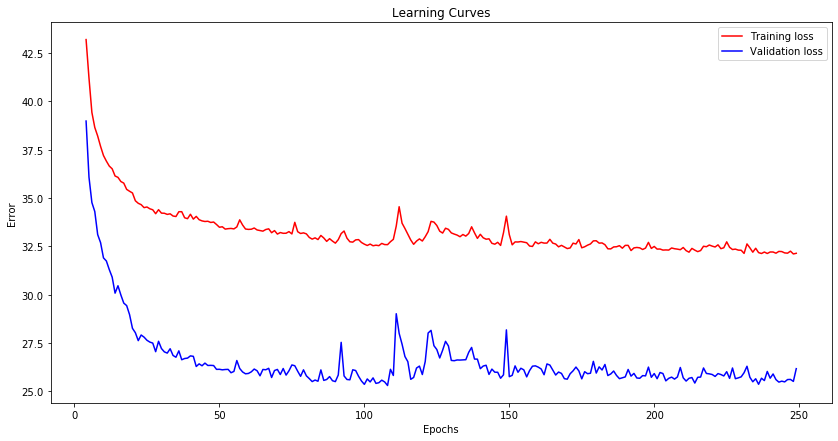

In [28]:
vae_Name='VAE_FC_h4_z60'
vae=vae_FC_h4_z60
train_data=VAE_train(vae, vae_Name)

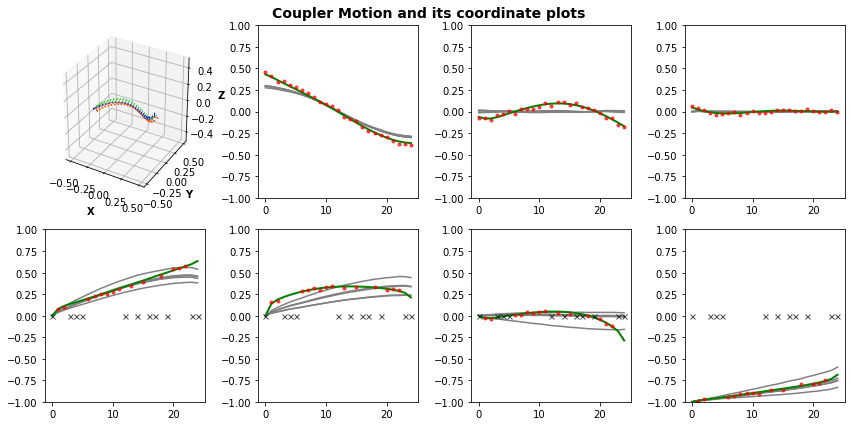

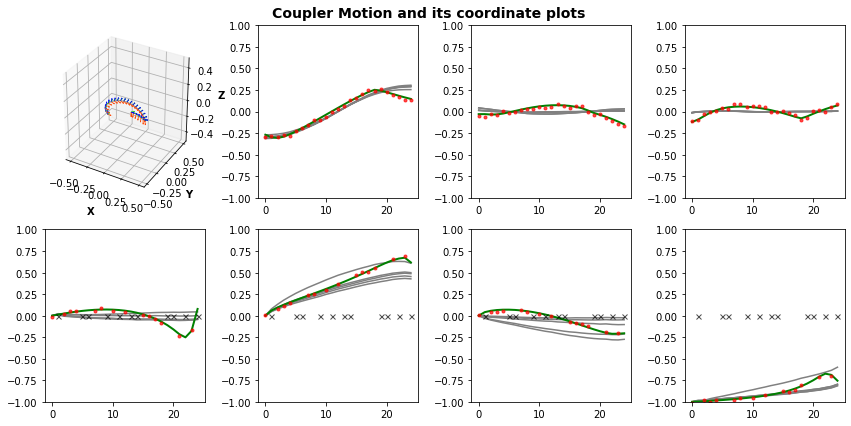

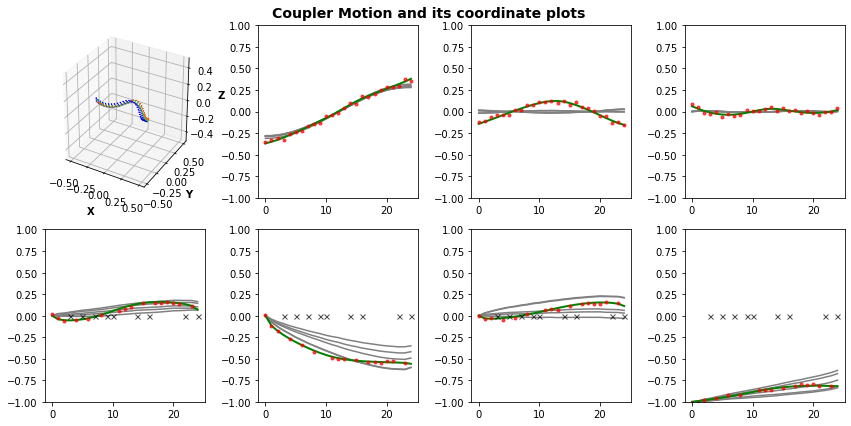

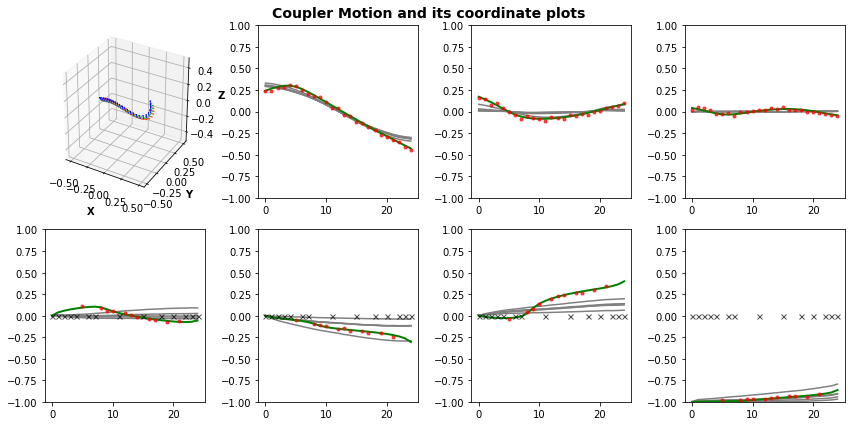

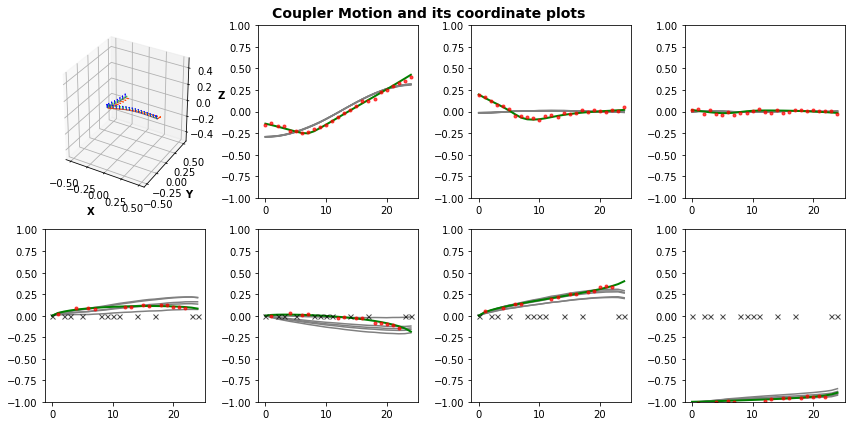

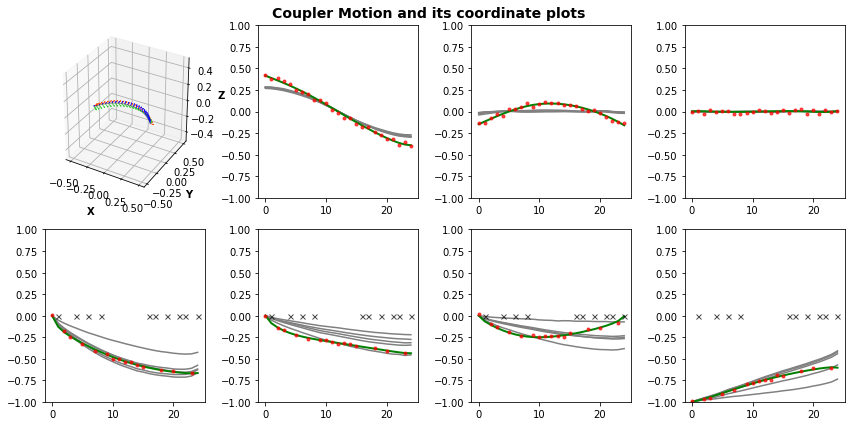

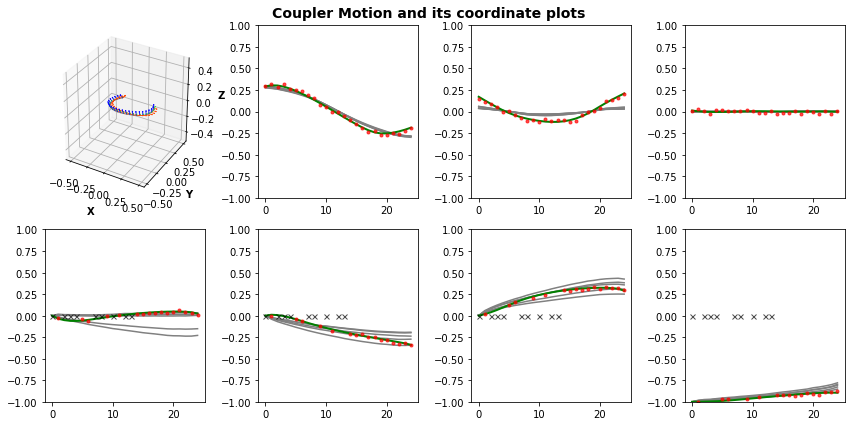

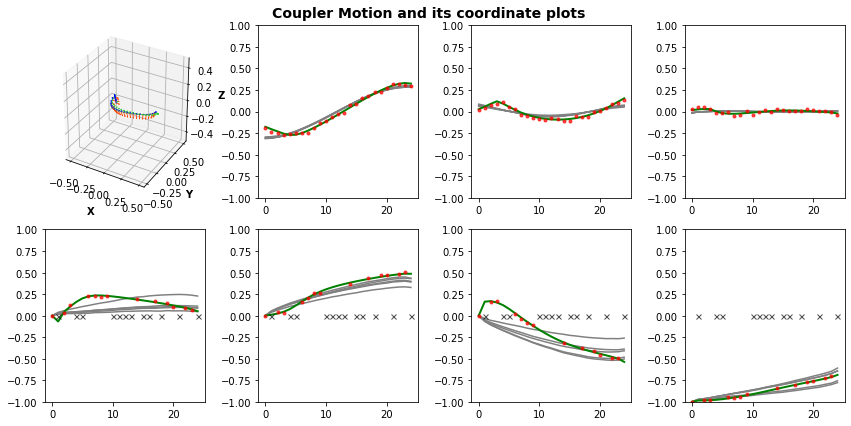

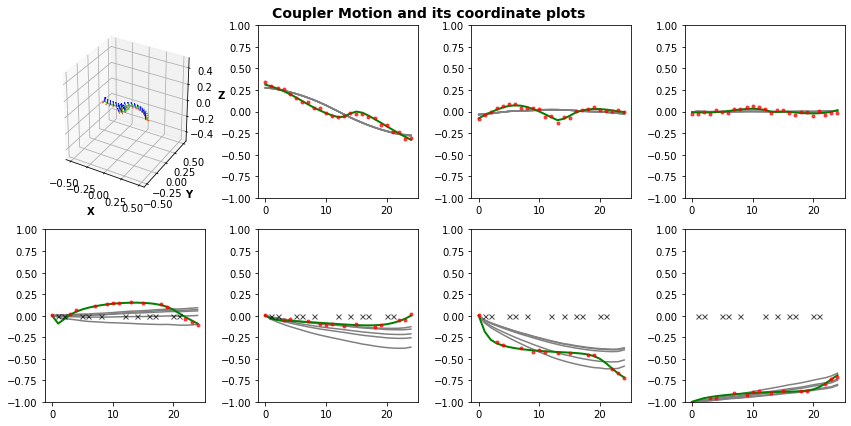

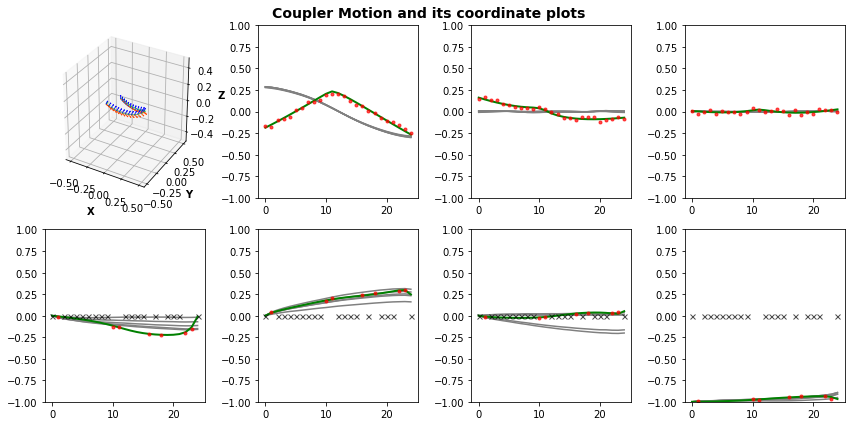

In [29]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)

### Results

| Network       | Training Loss | Validation Loss |
|:-------------:|---------------|-----------------|
| vae_FC_h1_z15 | 22.3693       | 22.0379         |
| vae_FC_h1_z30 | 22.4083       | 22.1094         |
| vae_FC_h1_z60 | 22.3850       | 22.1108         |
| vae_FC_h2_z15 | 22.4232       | 22.3670         |
| vae_FC_h2_z30 | 22.1957       | 21.9473         |
| vae_FC_h2_z60 | 21.9098       | 21.6638         |
| vae_FC_h3_z15 | 21.8387       | 22.1160         |
| vae_FC_h3_z30 | 22.1282       | 22.0993         |
| vae_FC_h3_z60 | 22.7096       | 22.7213         |
| vae_FC_h4_z15 | 22.2934       | 22.4293         |
| vae_FC_h4_z30 | 22.4728       | 22.5310         |
| vae_FC_h4_z60 | 22.4379       | 22.4506         |

## Fully Connected NN architecture:  Cov2D (Z=30)

Using Cov2D instead of Cov1D because the Cov1DTranspose function does not exist in stable keras builds yet.

In [ ]:
def VAE_Cov2D_Z30():
    z_dim=30
    inp=Input(shape=(100,3))

    # Encoding
    x= Reshape((100, 3, 1))(inp)
    x= Conv2D(5, (6,1), strides=(2, 1), activation='relu')(x)
    x= Conv2D(10, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2D(15, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2D(20, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2D(25, (2,1), strides=(2, 1), activation='relu')(x)
    x= Flatten()(x)
    x=Dense(200, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(60, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    x=Dense(60, activation='relu')(z)
    x=Dense(100, activation='relu')(x)
    x=Dense(200, activation='relu')(x)
    x=Dense(225, activation='relu')(x)
    x= Reshape((3, 3, 25))(x)
    x= Conv2DTranspose(20, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2DTranspose(15, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2DTranspose(10, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2DTranspose(5, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2DTranspose(1, (6,1), strides=(2, 1))(x)
    y= Reshape((100, 3))(x)
    
    # loss
    def reconstruction_loss(out_true, out_pred):
      return eucledian_norm(out_true, out_pred)
    def kl_loss(out_true, out_pred):
      return kl(z_mean,z_log_var)
    def vae_loss(out_true, out_pred):      
      return reconstruction_loss(out_true, out_pred) + kl_loss(out_true, out_pred)

    # build model
    vae = Model(inputs=[inp], outputs=[y])
    #vae.add_loss(vae_loss)
    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reconstruction_loss,kl_loss])
    
    encoder = Model(inputs=[inp], outputs=[z_mean])
    return vae, encoder

vae_Cov2D_Z30,_=VAE_Cov2D_Z30()

In [ ]:
vae_Name='VAE_Cov2D_Z30'
vae=vae_Cov2D_Z30
train_data=VAE_train(vae, vae_Name)

In [ ]:
VAE_load(vae,vae_Name)
visualize_VAE(vae, x_test, y_test)